# Case 2 - Diabetic Retinopathy Classifier

Riku Sykäri <br />
Last Edited: 15.4.2018 <br />
Cognitive Systems for Health Technology Applications <br />
<a href="http://www.metropolia.fi" target="_blank">Helsinki Metropolia University of Applied Sciences</a>

## 1. Objectives

The objective of this case exercise was to train an image recognition system capable of recognizing diabetic retinopathy through convolutional neural networks, using a dataset of approx. 2000 labeled examples of retinal images through supervised learning. The network in this case is a binary classifier, denoting retinal images as being either 'healthy' or 'unhealthy'.

The background research for this case was jointly done by myself and Arseny Savin. It consisted of checking out competition winners for clues on how to build a network, as well as breaking the problem into small steps and reading recent studies related to convolutional neural networks to get answers for those steps. A compilation of useful links is listed under the final section of ideas on how to improve the network.

The code implementation is a continuation of the template offered by our teachers at https://github.com/sakluk/cognitive-systems-for-health-technology/tree/Case-2. I merely tweaked the data preprocessing and network model.

## 2. Required libraries

In [196]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import keras
import pickle
import sklearn

from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.applications import VGG16 

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

# Versions used
print('numpy:', np.__version__)
print('pandas:', pd.__version__)
print('keras:', keras.__version__)

numpy: 1.12.1
pandas: 0.20.3
keras: 2.1.3


## 3. Data Generation

The data used was the dataset given in the exercise (found in https://github.com/Nomikxyz/retinopathy-dataset).

The accompanying 'Case_2_data_import_organization' file contains the breakdown of the dataset into train, validation and test sets (a 60/20/20 split). 

After the split the dataset was undersampled to bring the number of healthy examples down to the level of diseased ones. This was done so that the model wouldn't learn merely to call every picture it sees a healthy picture.

In [197]:
# Code, model and history filenames
my_code = 'CogSys_HealthTech_Case_2.ipynb'
model_filename = 'case_2_model.h5'
history_filename = 'case_2_history.p'

train_dir = "E:\\python_projects\\case_2_datasets\\train"
validation_dir = "E:\\python_projects\\case_2_datasets\\validation"
test_dir = "E:\\python_projects\\case_2_datasets\\test"

image_height = 200
image_width = 200 

def centering(x):
    r = x[:, :, 0]
    g = x[:, :, 1]
    b = x[:, :, 2]
    r = (r - np.mean(r))
    g = (g - np.mean(g))
    b = (b - np.mean(g))
    x[:, :, 0] = r
    x[:, :, 1] = g
    x[:, :, 2] = b
    return x

# Create datagenerators
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 360,
    zoom_range = 0.2,
    horizontal_flip = True,
    preprocessing_function = centering)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = centering)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = centering)


# Generator for train dataset
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (image_height, image_width), 
    batch_size = batch_size, 
    class_mode = 'binary')

# Generator for validation dataset
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    target_size = (image_height, image_width), 
    batch_size = batch_size, 
    class_mode = 'binary')

Found 714 images belonging to 2 classes.
Found 238 images belonging to 2 classes.


## 4. Model Selection

Starting out with a pre-trained VGG16, we add a simple linear classifier consisting of single Dense layer with 256 neurons, with weight regularization and dropout to combat overfitting, leading up to the output layer.

In [198]:
conv_base = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_width, image_height, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(
    256, 
    kernel_initializer='random_normal',
    kernel_regularizer=regularizers.l2(0.001), 
    activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
conv_base.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_26 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 257       
Total params: 19,433,793
Trainable params: 19,433,793
Non-trainable params: 0
_________________________________________________________________


## 5. Model Compilation & Training

I decided to try out the Adadelta optimizer (with default settings) as I found it converged rather quickly on an answer, cutting down training time.

In [199]:
# Training parameters
batch_size = 14
epochs = 20
steps_per_epoch = 51 
validation_steps = 5

oz = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

model.compile(
    loss='binary_crossentropy',
    optimizer=oz,
    metrics=['acc'])

t1 = time.time()
h = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    verbose = 0,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps)
t2 = time.time()

# Storing the elapsed time into history
h.history.update({'time_elapsed': t2 - t1})
print(' ')
print('Total elapsed time for training: {:.3f} minutes'.format((t2-t1)/60))
print(' ')

 
Total elapsed time for training: 95.855 minutes
 


In [200]:
# Saving the model
fname = os.path.join('E:\\python_projects\\', 'case_2_results', model_filename)
model.save(fname)
 
# Saving the history
fname = os.path.join('E:\\python_projects\\', 'case_2_results', history_filename)
pickle.dump(h.history, open(fname, 'wb'))

## 6. Evaluation

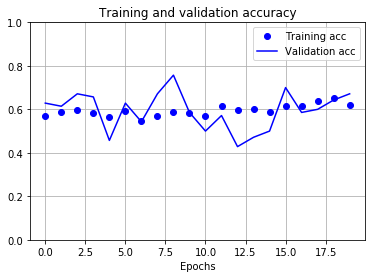

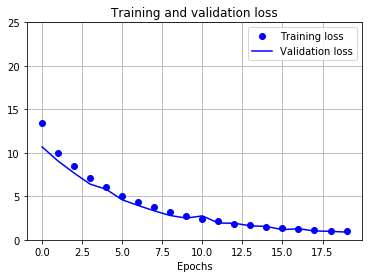

In [201]:
acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0, 25])
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

## 7. Results

In [202]:
# Testing the model

# Generator for test dataset
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size = (image_height, image_width), 
    batch_size = batch_size, 
    class_mode = 'binary')

r = model.evaluate_generator(test_generator, steps = 21)

# Loss and accuracy
r

Found 238 images belonging to 2 classes.


[0.90967757928939097, 0.6666666737624577]

In [204]:
# Predicting the score

# number of test examples
sample_count = 238
y_true = np.zeros(238)
y_score = np.zeros(238)

i = 0
for inputs_batch, labels_batch in test_generator:
        predicts_batch = model.predict(inputs_batch)
        L = labels_batch.shape[0]
        index = range(i, i + L)
        y_true[index] = labels_batch.ravel()
        y_score[index] = predicts_batch.ravel()
        i = i + L
        if i >= sample_count:
            break

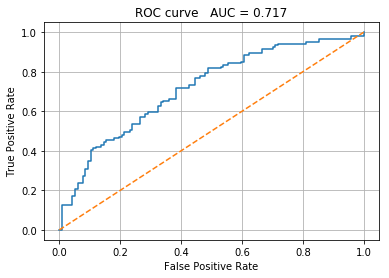

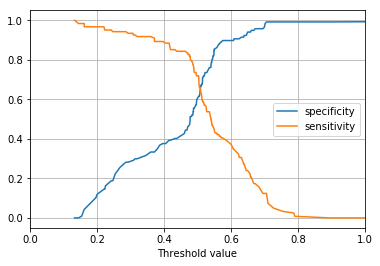

In [205]:
# Calculating ROC and AUC

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve   AUC = {:.3f}'.format(auc))
plt.show()

plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.xlabel('Threshold value')
plt.show()

In [206]:
# Selecting the threshold to optimize for both specificity and sensitivity equally
th = 0.51

# Metrics
acc = accuracy_score(y_true, y_score > th)
prec = precision_score(y_true, y_score > th)
f1 = f1_score(y_true, y_score > th)
recall = recall_score(y_true, y_score > th)

print('Accuracy:  {:.3f}'.format(acc))
print('Precision: {:.3f}'.format(prec))
print('Recall:    {:.3f}'.format(recall))
print('F1:        {:.3f}'.format(f1))

Accuracy:  0.647
Precision: 0.661
Recall:    0.628
F1:        0.644


In [207]:
print('Classification report')
print(classification_report(
    y_true, 
    y_score > threshold, 
    labels = [1.0, 0.0], 
    target_names = ['Disease', 'Healthy']))

Classification report
             precision    recall  f1-score   support

    Disease       0.58      0.93      0.71       121
    Healthy       0.81      0.29      0.43       117

avg / total       0.69      0.62      0.57       238



In [208]:
tn, fp, fn, tp = confusion_matrix(y_true, y_score > th).ravel()

print('                      Confusion matrix')
print('                       True condition')
print('                      Positive Negative      Sum')
print('Predicted | Positive  {:8} {:8} {:8}'.format(tp, fp, tp + fp))
print('condition | Negative  {:8} {:8} {:8}'.format(fn, tn, fn + tn))
print('                 Sum  {:8} {:8} {:8}'.format(tp + fn, fp + tn, tp + fp + fn + tn))
print(' ')
print('Sensitivity: {:.3f}'.format(tp/(tp+fn)))
print('Specificity: {:.3f}'.format(tn/(tn+fp)))

                      Confusion matrix
                       True condition
                      Positive Negative      Sum
Predicted | Positive        76       39      115
condition | Negative        45       78      123
                 Sum       121      117      238
 
Sensitivity: 0.628
Specificity: 0.667


## 8. Conclusions

Before, when I hadn't yet altered the ratio of healthy/unhealthy training examples, the model consistently converged towards the same practice of just labeling everything healthy and getting precision score of 76% with zero sensitivity, no matter if I tweaked the image resolution or data-augmentation and if I added weight regularization and dropout.

This demonstrates the importance of under/oversampling at least in image recognition tasks, as the problem in this case wasn't overfitting where training accuracy keeps increasing as validation score plummets.

While oversampling is generally preferred to undersampling, as that way you don't end up losing part of your data, I found this solution much easier to implement. Originally I only undersampled the training set but then came to the conclusion that I should do it for training and test sets as well to get a closer answer on the evaluation and results.

What surprised me was how increasing the image resolution to 200x200 actually yielded poorer results than keeping it the same as 150x150. With smaller images I managed to reach over 70% accuracy at least, in the same number of epochs as now. Not a good showing overall.

After having taken a more thorough look at the retinal pictures I think the reason for the middling score is both a function of the small samplesize and the noise within the samples, where there are drastic changes in brightness, color balance, retina size as well as relflections and halo effects from what I can assume were poor lighting conditions at the time a picture was taken.

It leaves me wondering if it was better to simply go through the dataset manually and delete certain drastic outliers from the samples, although that would surely impose it's own selection effects and biases.

## 9. Ideas for improving the network

<b> Convolutional Neural Networks for Visual Recognition course materials: </b><br />
https://cs231n.github.io/neural-networks-1/ <br />
https://cs231n.github.io/neural-networks-2/ <br />
https://cs231n.github.io/neural-networks-3/ <br />

<b> Data Preprocessing </b><br />
https://arxiv.org/pdf/1710.05381.pdf <br />
http://jeffreydf.github.io/diabetic-retinopathy-detection/ <br />
https://kaggle2.blob.core.windows.net/forum-message-attachments/88655/2795/competitionreport.pdf <br />

<b> Data Augmentation </b><br />
http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf <br />

<b> Batch Normalization </b><br />
https://arxiv.org/pdf/1502.03167.pdf <br />

<b> Global Average Pooling </b><br />
https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/ <br />
https://arxiv.org/pdf/1312.4400.pdf <br />

<b> Regularization </b><br />
http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf<br />

<b> Optimizers </b><br />
https://arxiv.org/pdf/1412.6980.pdf <br />